#### Notebook to split FOUNDIN-PD RNAB by day
will also output a scaled and covariate adjusted file for full dataset; ie across days

In [1]:
!date

Wed Aug 18 17:34:56 EDT 2021


#### do imports and set notebooks variables

In [2]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import concurrent.futures
import random
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.stats.multitest as smm
from umap import UMAP
import ppscore as pps
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [3]:
# naming
cohort = 'foundin'
quant_type = 'atac'

# directories
wrk_dir = f'/home/gibbsr/foundin/caqtl'
quants_dir = f'{wrk_dir}/quants'
info_dir = f'{wrk_dir}/sample_info'

# in files
quants_local_file = f'{quants_dir}/{quant_type}.peaks.featureCounts.csv'
features_file = f'{quants_dir}/foundin_consensus_peaks.saf'
covariates_file = f'{info_dir}/{cohort}_{quant_type}_sample_info.csv'

# out files
all_quants_file = f'{quants_dir}/{cohort}.{quant_type}.hdf5'
umap_covs_file = f'{info_dir}/{cohort}.{quant_type}.umap.covs.csv'
scaled_file = f'{quants_dir}/{cohort}.{quant_type}.scaled.hd5f'
adj_quants_file = f'{quants_dir}/{cohort}.{quant_type}.scaled.adj.hdf5'
tnsrqtl_pheno_file = f'{quants_dir}/{cohort}.{quant_type}.scaled.adj.bed'

# constants
max_missing_rate = 0.25
min_ppscore = 0.05
min_pearson = 0.22

other_id_columns = ['sampleid', 'cdi', 'PPMI_ID', 'DZNE_Barcode', 'DZNE_ID', 
                    'participant_id', 'wgsid', 'PATNO', 'Barcode_LNG', 
                    'Barcode_DZNE', 'Alternate MRN', 'IID', 'FID']
# to match geno's use PPMI3966 Batch3
replace_id_dict = {'PPMI3966B3': 'PPMI3966'}

### notebook functions

#### functions for detection rates calculations and plotting

In [4]:
def calculate_detection_rates(this_df, quant_type, round_percision=1, 
                              min_quant_value=None):
    if min_quant_value is None:
        min_quant_value = this_df.round(round_percision).min().min()

    print(f'minimun {quant_type} value is {min_quant_value}')

    detected_df = this_df.mask(this_df.round(round_percision) <= min_quant_value, 0)

    # calculate the missing counts from the detected df mask
    trait_missing_rates = round(detected_df.isin({0}).sum(0)/detected_df.shape[0], 2)
    sample_missing_rates = round(detected_df.isin({0}).sum(1)/detected_df.shape[1], 2)

    print(f'{len(trait_missing_rates)} features with mean missing \
rate = {trait_missing_rates.mean()}')
    print(f'{len(sample_missing_rates)} samples with mean missing \
rate = {sample_missing_rates.mean()}')
    return trait_missing_rates, sample_missing_rates

def plot_missing_rates(feature_rates, sample_rates):
    sns.set()
    plt.figure(figsize=(12, 12))
    plt.subplot(2, 2, 1)
    sns.distplot(feature_rates.values)
    plt.title('Features missingness rates')
    plt.subplot(2, 2, 2)
    sns.distplot(sample_rates.values)
    plt.title('Samples missingness rates')
    plt.show()
    
def bad_callrate_features(features_missing_rates, max_missing_rate):
    bad_call_rates = features_missing_rates[features_missing_rates > max_missing_rate]
    print(f'features with bad call rates shape {bad_call_rates.shape}, \
fraction of features with bad rates {bad_call_rates.shape[0]/features_missing_rates.shape[0]}')
    return bad_call_rates

def subset_well_detected_features(this_df, bad_call_rates):
    detected_traits = list(set(this_df.columns)-set(bad_call_rates.index))
    this_wd_df = this_df[detected_traits]
    print(f'shape of well detected quants {this_wd_df.shape}')
    return this_wd_df

#### function to generate and visualize known and unknow covariates using UMAP and PPScore

In [5]:
# function for plotting umap of traits with covar high lights
def plot_umap_clusters(umap_df, hue_cov=None, style_cov=None, size_cov=None):
    # umap_plot_file = f'{WRKDIR}/{COHORTBUILD}.umap.residuals.umap.plot.png'
    sns.set()
    plt.figure(figsize=(12, 12))
    sns_plot = sns.scatterplot(x='x_umap',y='y_umap', \
                               hue=hue_cov, style=style_cov, size=size_cov, \
                               data=umap_df)
    plt.xlabel('x-umap')
    plt.ylabel('y-umap')
    #plt.legend(loc='lower right', prop={'size': 6})
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0,prop={'size': 10})
    # plt.savefig(umap_plot_file,format='png',dpi=600,bbox_inches='tight')
    plt.show()

# small function to generate umap from pandas dataframe, for all features (columns) \
# and return back as dataframe with source index intact
def generate_umap_covs_df(this_df, other_covs_df=None, 
                             rnd_digits=3, merge_input=False):
    #run UMAP on the data frame features
    umap_results = UMAP(random_state=42).fit_transform(this_df)
    umap_df = pd.DataFrame(umap_results,columns=['x_umap','y_umap'], \
                                       index=this_df.index).round(rnd_digits)
    if merge_input:
        umap_df = umap_df.merge(this_df,left_index=True,right_index=True)
    if other_covs_df is not None:
        umap_df = umap_df.merge(other_covs_df, how='left', 
                                left_index=True, right_index=True)
    print(f'The dimensions of the umap df and the traits are {umap_df.shape}')
    return umap_df 

# function to iterate over target features and use PPScore to find covarites of interest
def pps_predict_targets(this_df, target_list):
    covs_to_check = []
#     covs_list = ['x_umap', 'y_umap']
    for this_cov in target_list:
        print(this_cov)
        predictors_df = pps.predictors(this_df, this_cov)
        # drop anything that has ppscore of zero
        predictors_df = predictors_df.loc[predictors_df['ppscore'] > min_ppscore]
        display(predictors_df)
        covs_to_check.extend(list(predictors_df['x'].values))

    print(f'found {len(covs_to_check)} covariates that may preditct target covariates')    
    return covs_to_check

# plot ppscore matrix 
def plot_ppscore_matrix(this_df, covs_to_check, cov_targets):
    matrix_df = pps.matrix(this_df[(set(covs_to_check) | set(cov_targets))])
    matrix_df = matrix_df.loc[matrix_df['ppscore'] > min_ppscore]
    print(matrix_df.shape)

    matrix_df['ppscore'] = matrix_df['ppscore'].round(2)
    plot_matrix_df = matrix_df[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
    print(plot_matrix_df.shape)
    # display(plot_matrix_df)

    plt.figure(figsize=(plot_matrix_df.shape[0],plot_matrix_df.shape[1])) 
    sns.heatmap(plot_matrix_df, vmin=0, vmax=1, cmap='Blues', linewidths=0.05, 
                annot=True, annot_kws={'fontsize':12})
    plt.title('PPScore heatmap')
    plt.show()
    
# plot heatmap of Pearson correlation matrix for PPScore covariates
def plot_correlation_heatmap(this_df, covs_list : list=None):
    sns.set()
    cor = this_df.corr(method='pearson')
    cor.dropna(how='all', inplace=True)
    modified_title = ''
    if covs_list is not None:
        
        limited_cor = cor[covs_list]
        cor = limited_cor.loc[(limited_cor['x_umap'].abs() > min_pearson) | 
                              (limited_cor['y_umap'].abs() > min_pearson)]
        modified_title = 'limited'
    print(cor.shape)
    fig_width = cor.shape[1] if cor.shape[1] > 12 else 12
    fig_height = cor.shape[0] if cor.shape[1] > 12 else 12
    plt.figure(figsize=(fig_width, fig_height))        
    sns.heatmap(cor[(cor > min_pearson) | (cor < -min_pearson)], annot=True, 
                annot_kws={"fontsize":10}, linewidths=0.05, cmap='Blues')    
    plt.title(f'Pearson heatmap of PPScore covariates {modified_title}')
    plt.show()

# function to one-hot encode the categorical covariates and merge with continuous ones    
def dummy_covs_as_needed(this_df):
    temp_df = this_df.copy()
    cats_df = temp_df.select_dtypes(include=['object'])
    print(f'categoricals shape {cats_df.shape}')
    dums_df = pd.get_dummies(cats_df)
    print(f'one-hot encoded categoricals shape {dums_df.shape}')

    temp_df = temp_df.merge(dums_df, how='inner', left_index=True, right_index=True)
    print(f'new covs df shape {temp_df.shape}')
    return temp_df    

#### visualization functions

In [6]:
# small function to plot before and after of transform based on named feature,
# or if a feature isn't specified then one pull at random
def plot_trnsfrm_effect_example(before_df, after_df, feature_id=None,
                                bf_label='quantile transformed', 
                                af_label='quantile transformed and covariate adjusted'):
    # if no feature ID provided get randome one
    if feature_id is None:
        feature_id = random.sample(list(after_df.columns), 1)[0]
    
    sns.distplot(before_df[feature_id])
    plt.title(f'{feature_id} {bf_label}')
    plt.show()
    sns.distplot(after_df[feature_id])
    plt.title(f'{feature_id} {af_label}')
    plt.show()
    sns.scatterplot(x=before_df[feature_id], y=after_df[feature_id])
    plt.title(f'{feature_id}')
    plt.xlabel(f'{bf_label}')
    plt.ylabel(f'{af_label}')

#### analysis functions

In [7]:
# small function to perform the quantile transform and minmax scale on a pandas dataframe
def scale_dataframe(this_df : pd.DataFrame):
    scaledX = MinMaxScaler().fit_transform(QuantileTransformer(output_distribution='normal')
                                           .fit_transform(this_df))
    scaled_df = pd.DataFrame(data=scaledX, columns=this_df.columns, 
                                 index=this_df.index)  
    return scaled_df    

# exclude low variance features from covariate generation
def exclude_low_var_features(this_df: pd.DataFrame, quartile_to_drop: str ='25%', 
                             known_feature_to_drop=None):
    quants_vars = this_df.var() 
    print(quants_vars.describe())
    # drop features within the lower quartile of variance
    min_variance = quants_vars.describe()['25%']
    # min_variance = quants_vars.describe()['50%']
    keep = quants_vars[quants_vars > min_variance]
    if known_feature_to_drop is not None:
        keep_ids = set(keep.index) - set(known_feature_to_drop)
    else:
        keep_ids = set(keep.index)
    quants_wd_var_df = this_df[keep_ids]
    print(f'shape of the features to keep {keep.shape}')
    print(f'shape of input features df {this_df.shape}')
    print(f'shape of variance features df {quants_wd_var_df.shape}')
    return quants_wd_var_df

# function to fit linear model to covariates and calculate the standardized residuals
def covariate_residuals(traits_df, covars_df):
    lm = LinearRegression(n_jobs=16)
    residuals_df = traits_df.copy()
    covar_scores_by_trait = {}

    for trait in traits_df:
            model = lm.fit(covars_df, traits_df[trait])
            covar_scores_by_trait[trait] = model.score(covars_df,traits_df[trait])
            model_predicted = model.predict(covars_df)
            residuals_df[trait] = stats.zscore(traits_df[trait] - model_predicted)
            
#     # We can use a with statement to ensure threads are cleaned up promptly
#     with concurrent.futures.ProcessPoolExecutor() as ppe:
#         # Start the load operations and mark each future with its URL
#         future_to_residual = {executor.submit(compute_residuals, trait): trait for trait in traits_df}
#         for future in concurrent.futures.as_completed(future_to_residual):
#             covar_scores_by_trait[trait], residuals_df[trait] = future_to_residual[future]

    # scale the residuals
    residualsX = MinMaxScaler().fit_transform(residuals_df)
    residuals_df = pd.DataFrame(data=residualsX, columns=traits_df.columns, 
                                index=traits_df.index)
    
    # grab the covariates model scores
    covar_scores_by_trait_df = pd.DataFrame.from_dict(covar_scores_by_trait,
                                                      columns=['score'],
                                                      orient='index').round(3)
    covar_scores_by_trait_df.index.name = 'featureID'
    return residuals_df, covar_scores_by_trait_df


#### input output functions

In [8]:
# small function to save hdf file
def write_df_to_hdf(this_df, file_name, key='quants', mode='w'):
    this_df.to_hdf(file_name, key=key, mode=mode)

#### load the quantified features matrix

In [9]:
%%time
# the atac file still has 'Geneid' versus 'featureid'
quant_dd = dd.read_csv(quants_local_file).set_index('Geneid')
# in the atac data file the feature's info is include drop those columns
# the feature's info file will be load separately
quant_dd = quant_dd.drop(columns=['Chr', 'Start', 'End', 'Strand', 'Length'])
print(quant_dd.shape)

quant_df = quant_dd.compute().transpose()
print(quant_df.shape)

# now save the transposed quant matrix in faster file type
quant_df.to_hdf(all_quants_file, key='quants', mode='w')
# display(quant_df.head())

(Delayed('int-df110799-4c60-4224-aedb-b8e4b7f27828'), 290)
(290, 201820)
CPU times: user 9.89 s, sys: 2.3 s, total: 12.2 s
Wall time: 8.55 s


#### split name index to find info

In [10]:
id_parts = quant_df.index.str.split('_', expand=True).to_frame()
id_parts.columns = ['assay', 'sampleid', 'cdi', 'day', 'version']
# id_parts['fullassayid'] = quant_df.index
id_parts['assayid'] = id_parts['assay'] + '_' + id_parts['sampleid'] + '_' + id_parts['day']
print(id_parts.shape)
# display(id_parts.sample(5))

(290, 6)


#### replace the index from full assayid to non-version assayid

In [11]:
quant_df.index = id_parts['assayid']
print(quant_df.shape)
# display(quant_df.head())

(290, 201820)


#### capture the assayid to wgsid for formatting phenotypes for use with wgs genotypes later

In [12]:
id_map = id_parts[['sampleid', 'assayid']]
id_map['sampleid'].replace(replace_id_dict, inplace=True)

#### load covariates files

In [13]:
covs_df = pd.read_csv(covariates_file, index_col=0)
# drop any duplicated indices
print(covs_df.shape)
covs_df = covs_df[~covs_df.index.duplicated(keep='first')]
print(covs_df.shape)
# display(covs_df.sample(5))

(298, 91)
(290, 91)


In [14]:
# check for any unexpected samples; ie probably name frmt issue
set(id_parts['assayid']) - set(covs_df.index)

set()

In [15]:
set(id_parts['sampleid']) - set(covs_df['sampleid'])

{'PPMI3966B1', 'PPMI3966B2', 'PPMI3966B3'}

#### for further analysis remove the ID columns

In [16]:
print(covs_df.shape)
cols_to_keep = set(covs_df.columns) - set(other_id_columns)
covs_df = covs_df[cols_to_keep]
print(covs_df.shape)
# display(covs_df.head())

(290, 91)
(290, 78)


#### load feature annotations

In [17]:
features_df = pd.read_csv(features_file, sep='\t')
print(features_df.shape)
# display(features_df.head())

(201820, 5)


#### find IDs for features on sex chromosomes, for dropping later

In [18]:
sex_chr_feature_ids = features_df.loc[features_df['Chr']
                                      .isin(['chrX', 'chrY'])]['GeneID'].unique()
print(len(sex_chr_feature_ids))

5717


#### get counts by day

In [19]:
days = id_parts['day'].value_counts()
for day, count in days.items():
    print(f'{day} {count}')

da0 99
da25 97
da65 94


#### save the quantified features matrix split by day

In [20]:
%%time
# run the saves in parallel    
with concurrent.futures.ThreadPoolExecutor() as tpe:
    for day in days.index:
        day_df = id_parts.loc[id_parts['day'] == day]
        this_quant_df = quant_df[quant_df.index.isin(day_df['assayid'])]
        print(f'{cohort} {day} {this_quant_df.shape}')
        cohort_quant_filename = f'{quants_dir}/{cohort}.{day}.{quant_type}.hdf5'
        tpe.submit(write_df_to_hdf, this_quant_df, cohort_quant_filename)    

foundin da0 (99, 201820)
foundin da25 (97, 201820)
foundin da65 (94, 201820)
CPU times: user 1.28 s, sys: 566 ms, total: 1.84 s
Wall time: 3.97 s


#### scale the full dataset using quantile transform and minmax scaler

In [21]:
%%time
traits_scaled_df = scale_dataframe(quant_df)

CPU times: user 2min 20s, sys: 933 ms, total: 2min 20s
Wall time: 2min 20s


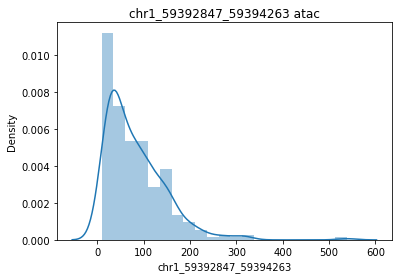

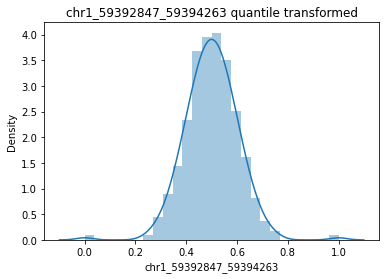

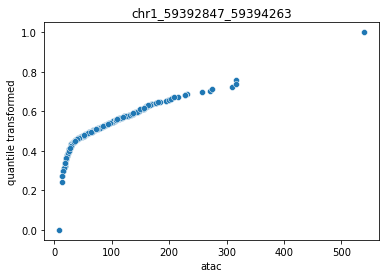

In [22]:
plot_trnsfrm_effect_example(quant_df, traits_scaled_df,
                            bf_label=quant_type, 
                            af_label='quantile transformed')

### generate covariates for variance

#### calculate, plot detection rates and subset well detected features

minimun atac value is 0
201820 features with mean missing rate = 0.0077922406104409805
290 samples with mean missing rate = 0.007689655172413788


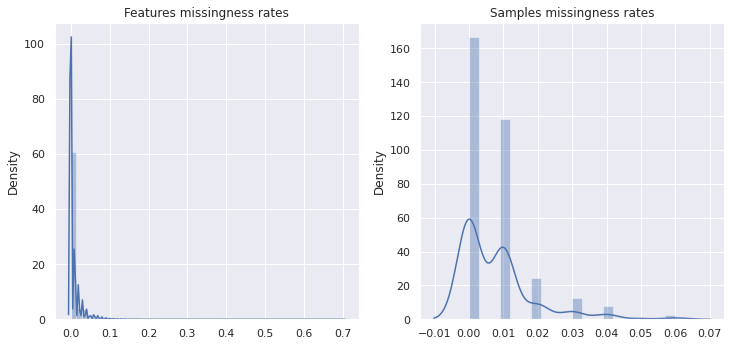

features with bad call rates shape (193,), fraction of features with bad rates 0.0009562976910117926
shape of well detected quants (290, 201627)
CPU times: user 1min 5s, sys: 1.28 s, total: 1min 7s
Wall time: 58.2 s


In [23]:
%%time
trait_miss_rates, sample_miss_rates = calculate_detection_rates(quant_df, quant_type)
plot_missing_rates(trait_miss_rates, sample_miss_rates)
bad_call_rate_features = bad_callrate_features(trait_miss_rates, max_missing_rate)
traits_scaled_df = subset_well_detected_features(traits_scaled_df, bad_call_rate_features)

#### save scaled, well detected data for all days

In [24]:
write_df_to_hdf(traits_scaled_df, scaled_file)

#### take a look at variance in data, assuming mostly driven by d0 -> d25, ie IPSc -> differentiating neurons

#### exclude low variance features from covariate generation

In [25]:
quants_var_df = exclude_low_var_features(traits_scaled_df)

count    201627.000000
mean          0.012157
std           0.003482
min           0.010265
25%           0.010602
50%           0.011148
75%           0.011907
max           0.060059
dtype: float64
shape of the features to keep (151220,)
shape of input features df (290, 201627)
shape of variance features df (290, 151220)


### take a look at the data

#### generate unknown covariates and see if know covariates are source of variations

The dimensions of the umap df and the traits are (290, 80)
x_umap


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,day,x_umap,0.887500,regression,True,mean absolute error,7.174097,0.807086,DecisionTreeRegressor()
1,Ependymal-likeCells,x_umap,0.730055,regression,True,mean absolute error,7.174097,1.936611,DecisionTreeRegressor()
2,ProliferatingFloorPlateProgenitors,x_umap,0.726223,regression,True,mean absolute error,7.174097,1.964102,DecisionTreeRegressor()
3,EarlyneuronProgenitor,x_umap,0.694324,regression,True,mean absolute error,7.174097,2.192947,DecisionTreeRegressor()
4,DAn,x_umap,0.687577,regression,True,mean absolute error,7.174097,2.241349,DecisionTreeRegressor()
5,DopaminergicNeurons,x_umap,0.682556,regression,True,mean absolute error,7.174097,2.277372,DecisionTreeRegressor()
6,ImmatureDopaminergicNeurons,x_umap,0.679271,regression,True,mean absolute error,7.174097,2.300937,DecisionTreeRegressor()
7,LateneuronProgenitor,x_umap,0.613849,regression,True,mean absolute error,7.174097,2.770282,DecisionTreeRegressor()
8,Neuroepithelial-likeCells,x_umap,0.088719,regression,True,mean absolute error,7.174097,6.537621,DecisionTreeRegressor()
9,y_umap,x_umap,0.068652,regression,True,mean absolute error,7.174097,6.681580,DecisionTreeRegressor()


y_umap


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,x_umap,y_umap,0.412151,regression,True,mean absolute error,1.1232,0.660272,DecisionTreeRegressor()
1,day,y_umap,0.304937,regression,True,mean absolute error,1.1232,0.780694,DecisionTreeRegressor()


found 12 covariates that may preditct target covariates
(90, 9)
(11, 11)


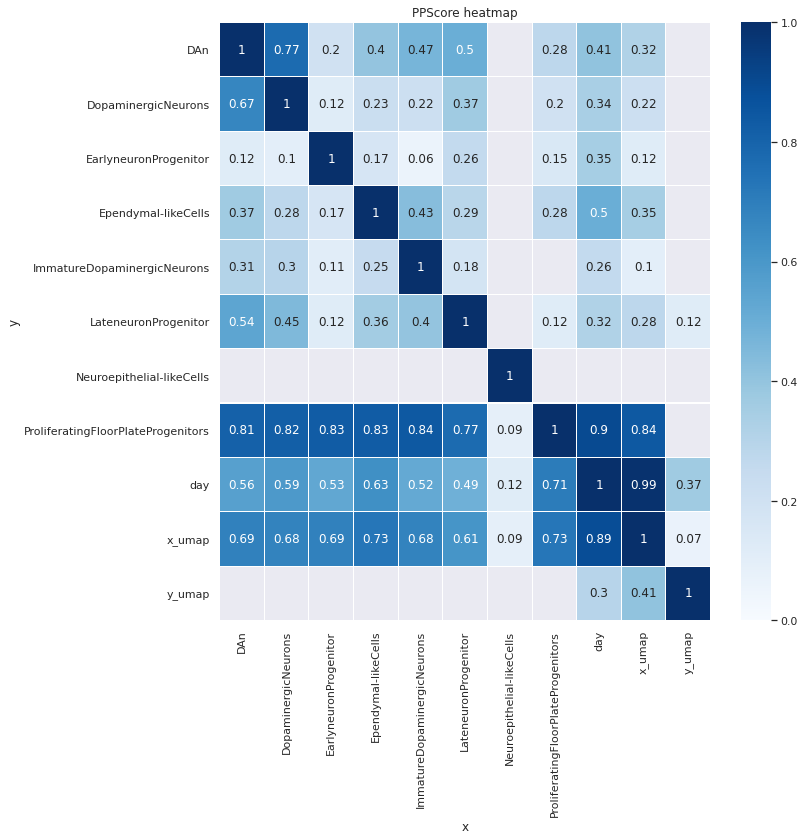

categoricals shape (290, 1)
one-hot encoded categoricals shape (290, 3)
new covs df shape (290, 14)
(13, 13)


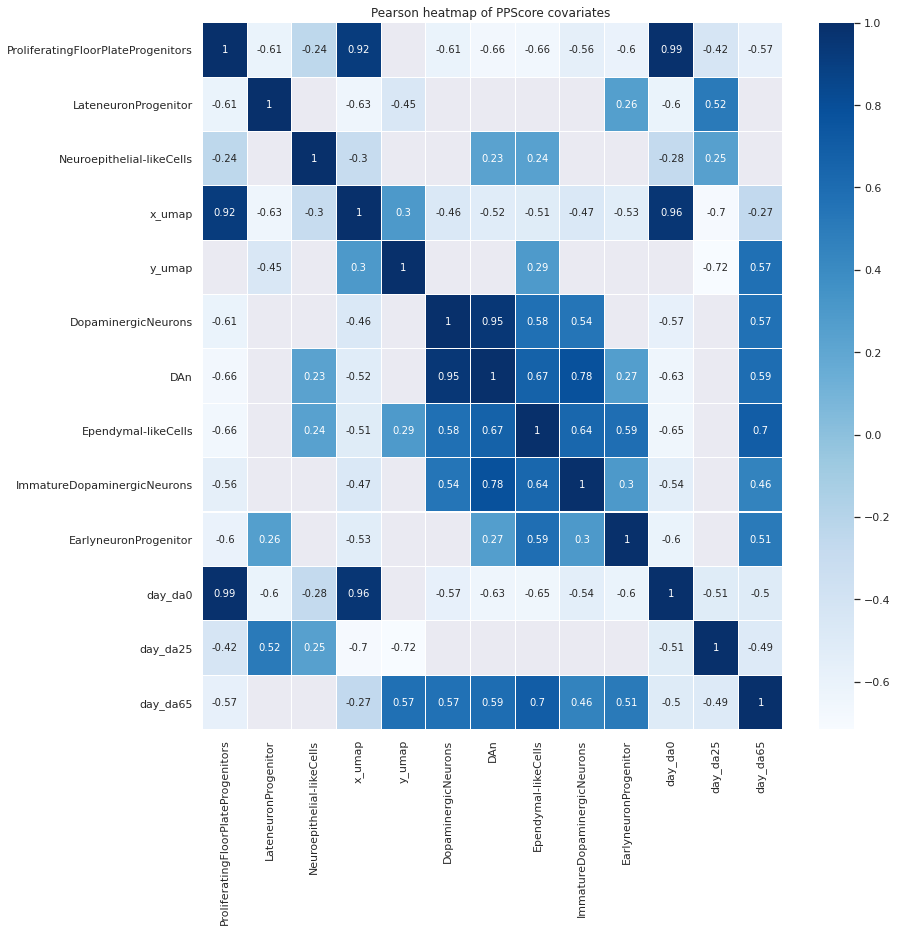

(13, 2)


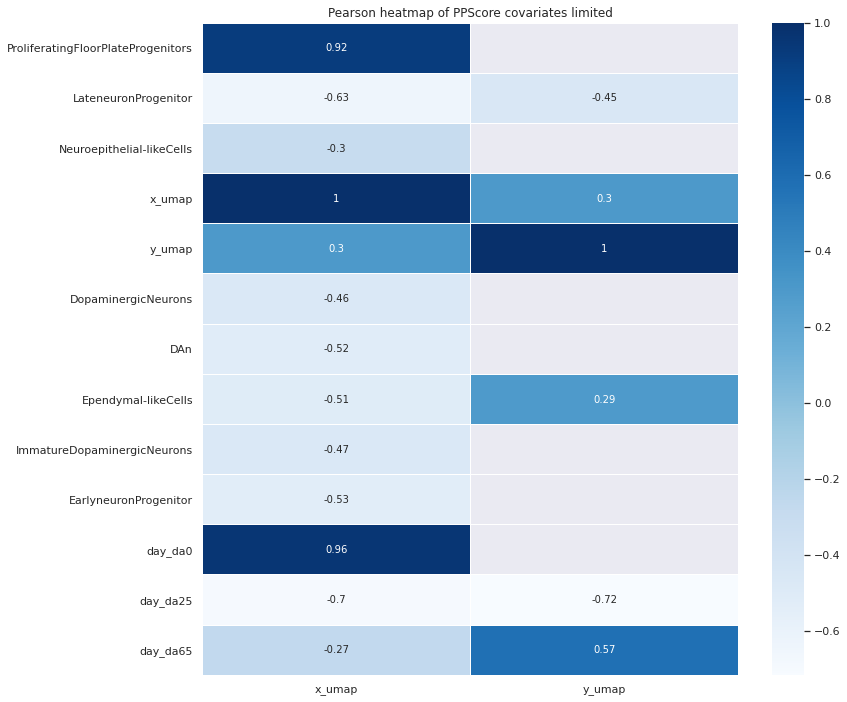

CPU times: user 15.4 s, sys: 229 ms, total: 15.6 s
Wall time: 15.6 s


In [26]:
%%time
umap_df = generate_umap_covs_df(quants_var_df, covs_df)
covs_target_list = ['x_umap', 'y_umap']
covs_to_check = pps_predict_targets(umap_df, covs_target_list)
plot_ppscore_matrix(umap_df, covs_to_check, covs_target_list)
umap_dums_covs_df = dummy_covs_as_needed(umap_df[(set(covs_to_check) | 
                                                  set(covs_target_list))])
plot_correlation_heatmap(umap_dums_covs_df)
plot_correlation_heatmap(umap_dums_covs_df, covs_target_list)

#### plot umap of with known covariates of interest

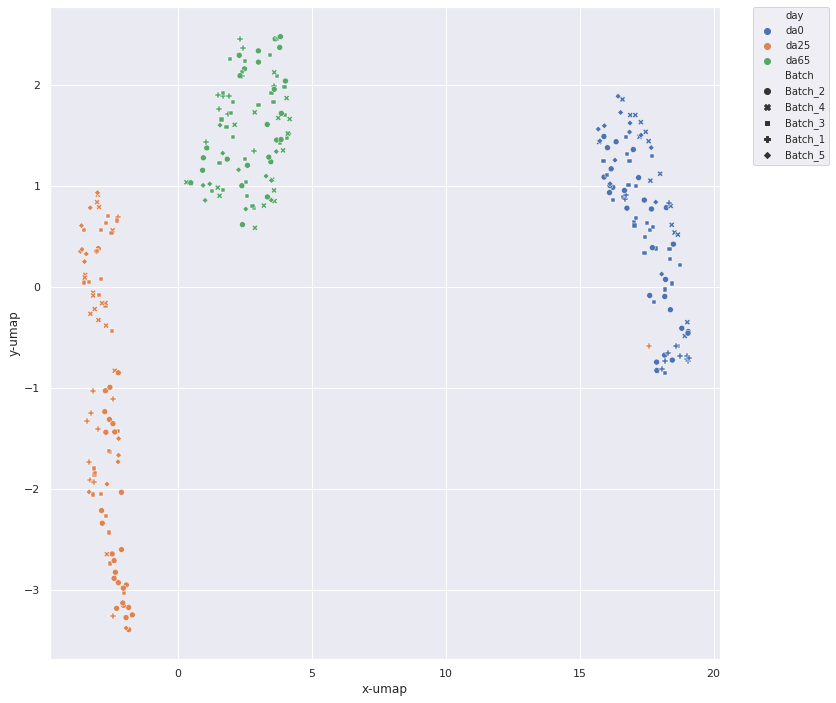

In [27]:
plot_umap_clusters(umap_df, hue_cov='day', style_cov='Batch')

#### do quick anova by day to identify features change with cell differentiation 

this is since we know differention should be largest source of variation, so figure out which features to exclude to get around

In [28]:
# split samples by group (day)
feats_by_day = {}
for day in days.index:
    day_df = id_parts.loc[id_parts['day'] == day]
    this_quant_df = traits_scaled_df[traits_scaled_df.index.isin(day_df['assayid'])]
    feats_by_day[day] = this_quant_df
    print(f'{cohort} {day} {this_quant_df.shape}')

# calculate one-way ANOVA for the groups
fvalues, pvalues = stats.f_oneway(feats_by_day.get('da0'), 
                                  feats_by_day.get('da25'), 
                                  feats_by_day.get('da65'))

# make df from results
anova_results_df = pd.DataFrame(data={'fvalues': fvalues, 'pvalues': pvalues}, 
                                index=traits_scaled_df.columns)
# apply a B&H FDR to pvalues
anova_results_df['bh_fdr'] = smm.fdrcorrection(pvalues)[1]

print(anova_results_df.shape)
display(anova_results_df.head())

foundin da0 (99, 201627)
foundin da25 (97, 201627)
foundin da65 (94, 201627)
(201627, 3)


,fvalues,pvalues,bh_fdr
Geneid,,,
chr7_144386664_144387220,7.248546,8.490304e-04,9.080262e-04
chr10_99758143_99759041,98.258072,3.112265e-33,1.176204e-32
chr16_47970251_47970715,74.559512,8.370090e-27,2.083450e-26
chr17_31405930_31406506,158.102170,5.121562e-47,8.046168e-46
chr8_124751660_124752431,29.442829,2.340080e-12,3.146937e-12


In [29]:
anova_results_df.loc[anova_results_df['bh_fdr'] < 0.05].shape

(196181, 3)

#### determine final set of features to use for variance detection
exluding bottom 25% variance features, sex features, tissue elevated features, and cell differentiation features

In [30]:
no_change_features = anova_results_df.loc[anova_results_df['bh_fdr'] > 0.05].index.values
print(len(no_change_features))

no_change_variance_features = (set(no_change_features) & set(quants_var_df.columns)) - set(sex_chr_feature_ids)
print(len(no_change_variance_features))

5446
3753


#### generate unknown covariates from final set of features for variance detection

The dimensions of the umap df and the traits are (290, 80)
x_umap


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,y_umap,x_umap,0.138145,regression,True,mean absolute error,1.936310,1.668819,DecisionTreeRegressor()
1,Batch,x_umap,0.051948,regression,True,mean absolute error,1.930518,1.830231,DecisionTreeRegressor()


y_umap


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,x_umap,y_umap,0.063828,regression,True,mean absolute error,1.034214,0.968202,DecisionTreeRegressor()


found 3 covariates that may preditct target covariates
(7, 9)
(3, 3)


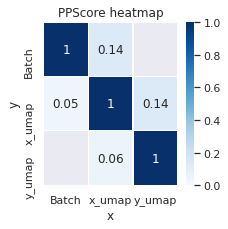

categoricals shape (290, 1)
one-hot encoded categoricals shape (290, 5)
new covs df shape (290, 8)
(7, 7)


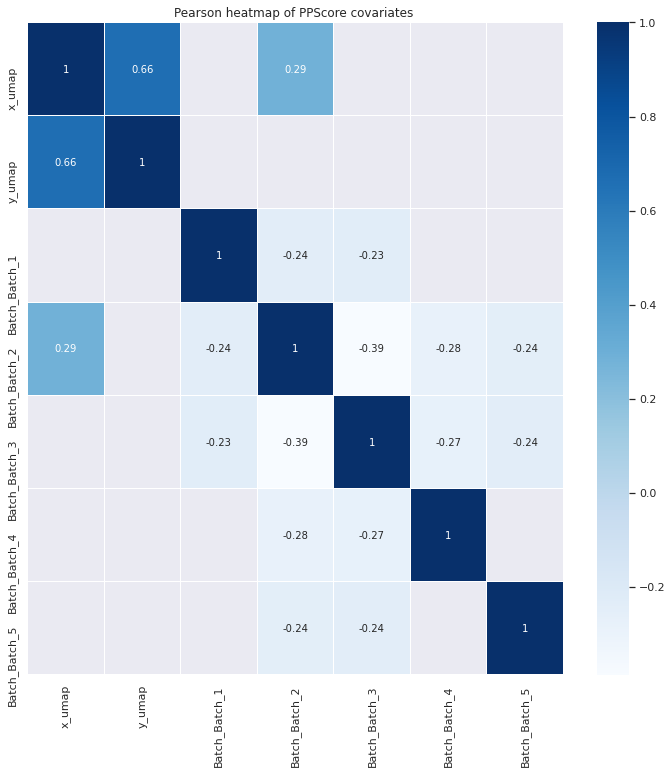

(3, 2)


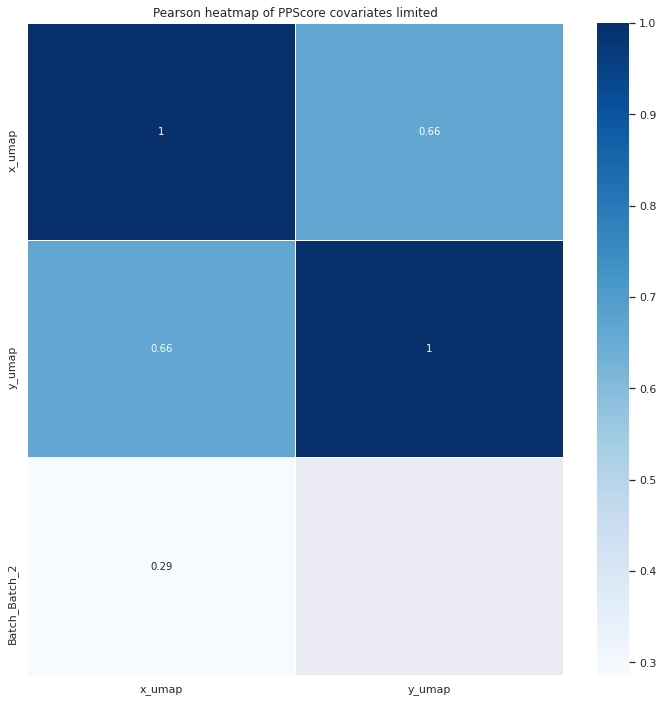

CPU times: user 3.35 s, sys: 48.8 ms, total: 3.4 s
Wall time: 3.37 s


In [31]:
%%time
umap_df = generate_umap_covs_df(quants_var_df[no_change_variance_features], covs_df)
covs_to_check = pps_predict_targets(umap_df, covs_target_list)
plot_ppscore_matrix(umap_df, covs_to_check, covs_target_list)
umap_dums_covs_df = dummy_covs_as_needed(umap_df[(set(covs_to_check) | 
                                                  set(covs_target_list))])
plot_correlation_heatmap(umap_dums_covs_df)
plot_correlation_heatmap(umap_dums_covs_df, covs_target_list)

#### plot umap of with known covariates of interest

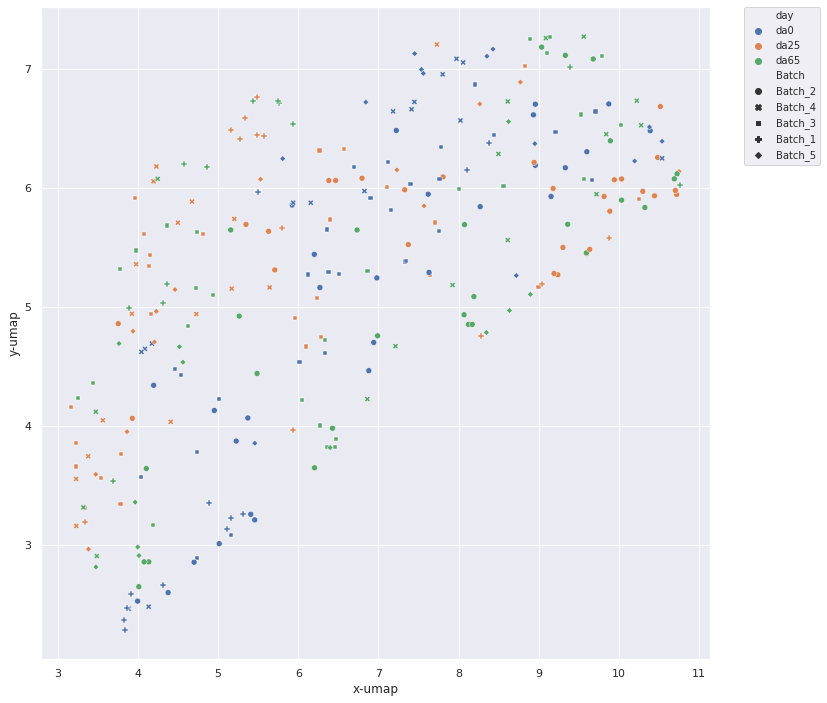

In [32]:
plot_umap_clusters(umap_df, hue_cov='day', style_cov='Batch')

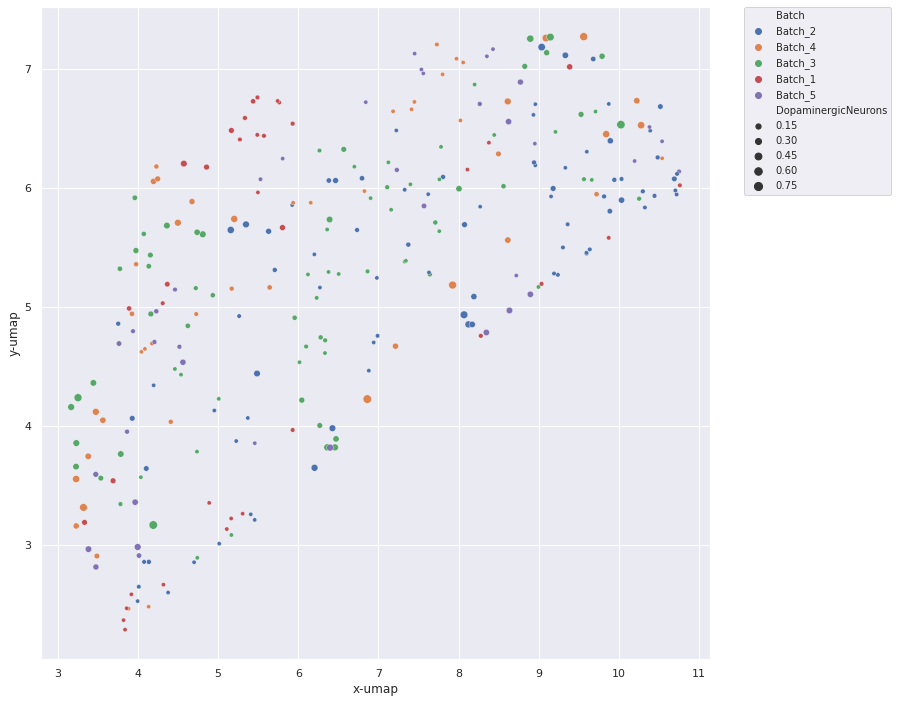

In [33]:
plot_umap_clusters(umap_df, hue_cov='Batch', size_cov='DopaminergicNeurons')

#### keep created covars and save them

In [34]:
# standardize the covariates
umap_covs_df = scale_dataframe(umap_df[covs_target_list])
# now save the covariates
umap_covs_df.to_csv(umap_covs_file)

#### covariate adjust the scaled data by the covariates

In [35]:
# check to see in df's have same indices
if not traits_scaled_df.index.equals(umap_covs_df.index):
    print('indices are not equal re-index')
    umap_covs_df.reindex(traits_scaled_df.index)
    
traits_scaled_df.index.equals(umap_covs_df.index)    

True

In [36]:
%%time

residuals_df, cov_scores_df = covariate_residuals(traits_scaled_df, umap_covs_df)

#take a peek at the data
print(residuals_df.shape)
print(cov_scores_df.shape)

# print(cov_scores_df.head())

(290, 201627)
(201627, 1)
CPU times: user 11h 49min 49s, sys: 13min 24s, total: 12h 3min 14s
Wall time: 11min 22s


               score
count  201627.000000
mean        0.278872
std         0.141068
min         0.000000
25%         0.168000
50%         0.262000
75%         0.374000
max         0.806000


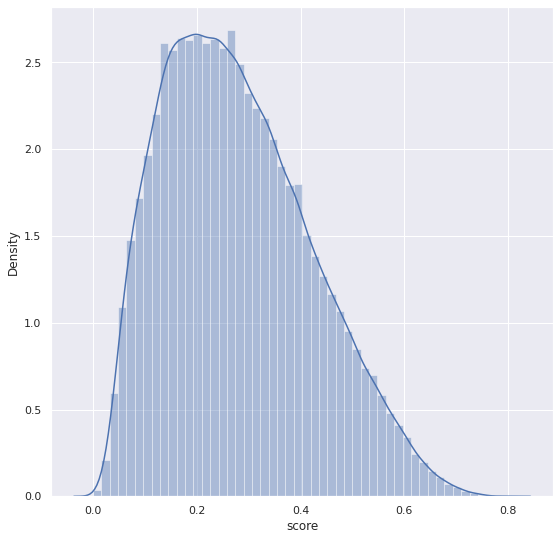

In [37]:
# get a summary of the covariates model scores
print(cov_scores_df.describe())
# look at the distribution of covariate model scores, 
# ie get a sense any feature driven by covariates
sns.set()
plt.figure(figsize=(9,9))
sns.distplot(cov_scores_df['score'])
plt.show()

#### save scaled and covariate adjusted data

In [38]:
%%time 

residuals_df.to_hdf(adj_quants_file, key='quants', mode='w')

CPU times: user 654 ms, sys: 365 ms, total: 1.02 s
Wall time: 2.77 s


#### take a look at the scaled and covariate adjusted data

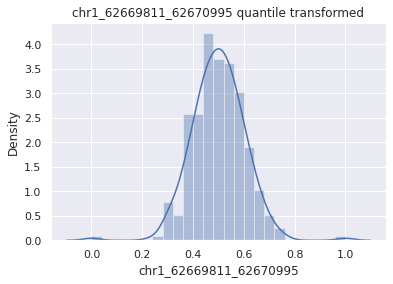

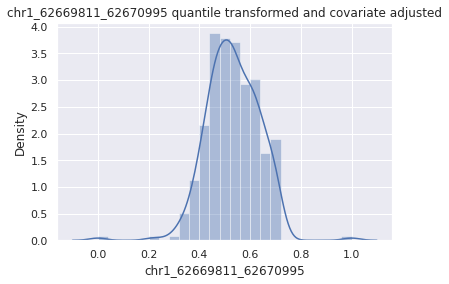

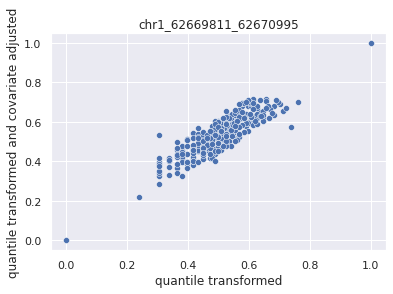

In [39]:
plot_trnsfrm_effect_example(traits_scaled_df, residuals_df)

                          score
featureID                      
chr2_232499833_232505190  0.806


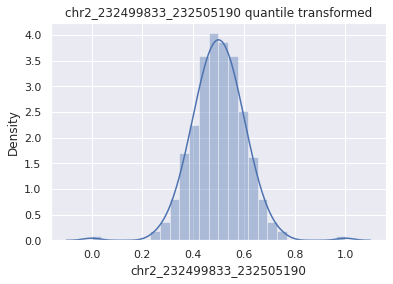

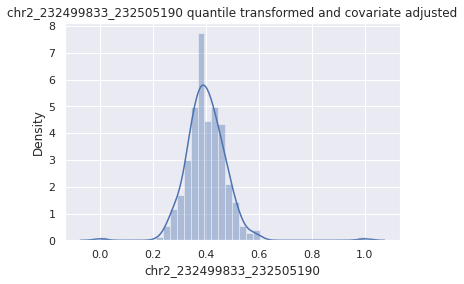

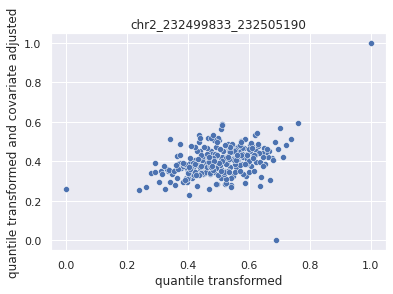

In [40]:
# find feature with largest score
large_adj_trait = cov_scores_df.loc[cov_scores_df['score'] == max(cov_scores_df['score'])]
print(large_adj_trait)
large_adj_traid_id = large_adj_trait.index.values[0]

# spot check same feature with largest adjustment effect
plot_trnsfrm_effect_example(traits_scaled_df, residuals_df, large_adj_traid_id)

#### what are the post scaled and covariate adjusted umap variables correlated with

The dimensions of the umap df and the traits are (290, 80)
x_umap


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,day,x_umap,0.903432,regression,True,mean absolute error,7.18569,0.693905,DecisionTreeRegressor()
1,ProliferatingFloorPlateProgenitors,x_umap,0.683151,regression,True,mean absolute error,7.18569,2.276775,DecisionTreeRegressor()
2,Ependymal-likeCells,x_umap,0.666472,regression,True,mean absolute error,7.18569,2.396627,DecisionTreeRegressor()
3,ImmatureDopaminergicNeurons,x_umap,0.618914,regression,True,mean absolute error,7.18569,2.738362,DecisionTreeRegressor()
4,DopaminergicNeurons,x_umap,0.608895,regression,True,mean absolute error,7.18569,2.810358,DecisionTreeRegressor()
5,DAn,x_umap,0.608027,regression,True,mean absolute error,7.18569,2.816598,DecisionTreeRegressor()
6,EarlyneuronProgenitor,x_umap,0.587367,regression,True,mean absolute error,7.18569,2.965050,DecisionTreeRegressor()
7,LateneuronProgenitor,x_umap,0.516995,regression,True,mean absolute error,7.18569,3.470726,DecisionTreeRegressor()
8,y_umap,x_umap,0.384024,regression,True,mean absolute error,7.18569,4.426209,DecisionTreeRegressor()


y_umap


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,day,y_umap,0.406447,regression,True,mean absolute error,1.0164,0.603287,DecisionTreeRegressor()
1,x_umap,y_umap,0.397902,regression,True,mean absolute error,1.0164,0.611972,DecisionTreeRegressor()
2,Ependymal-likeCells,y_umap,0.108250,regression,True,mean absolute error,1.0164,0.906374,DecisionTreeRegressor()


found 12 covariates that may preditct target covariates
(90, 9)
(10, 10)


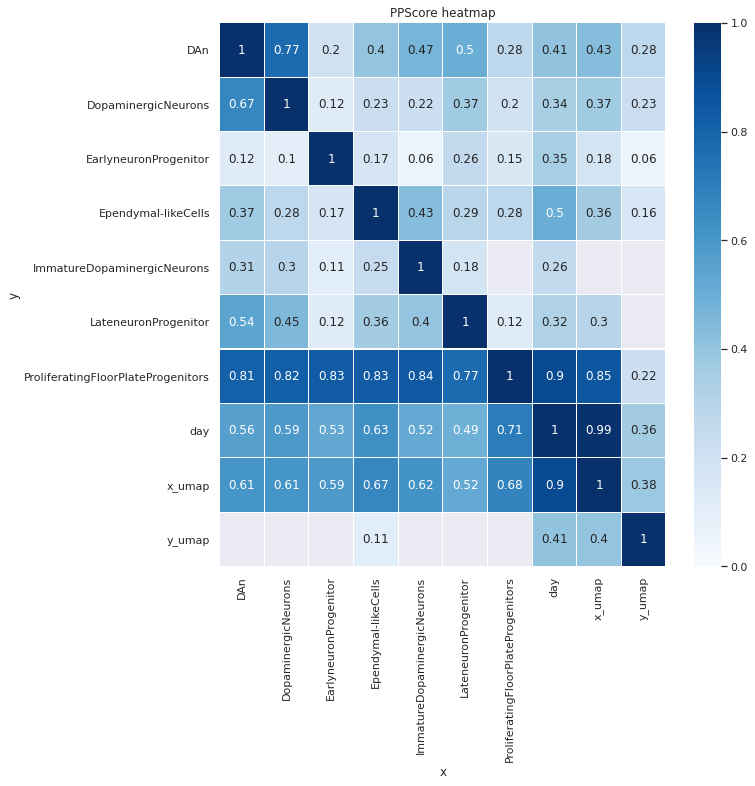

categoricals shape (290, 1)
one-hot encoded categoricals shape (290, 3)
new covs df shape (290, 13)
(12, 12)


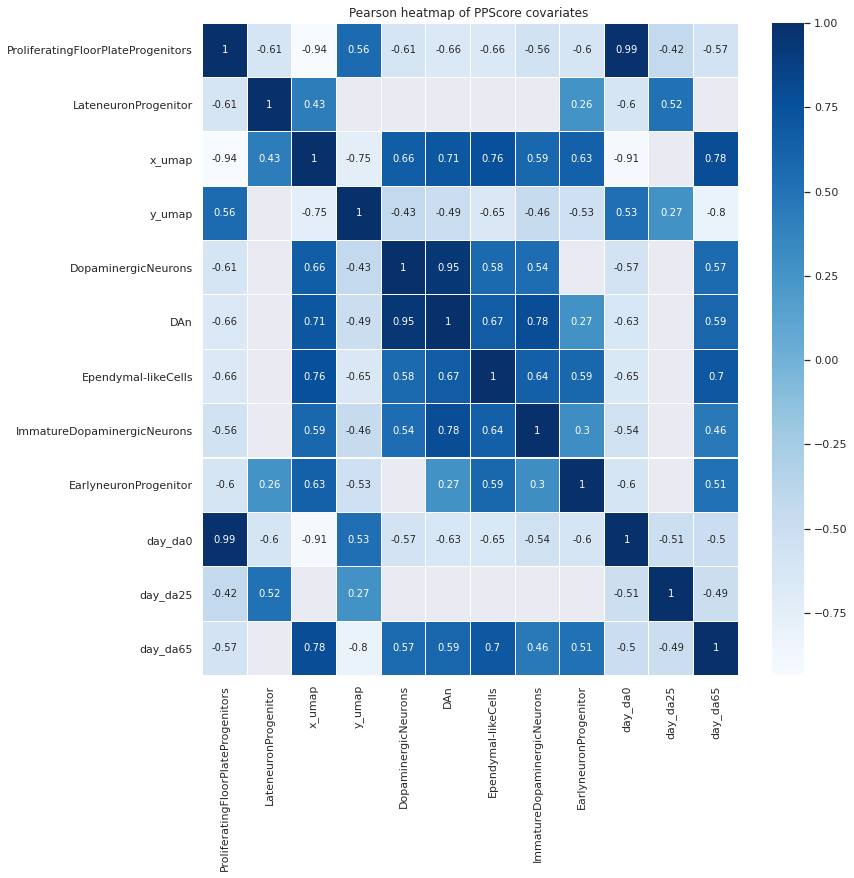

(12, 2)


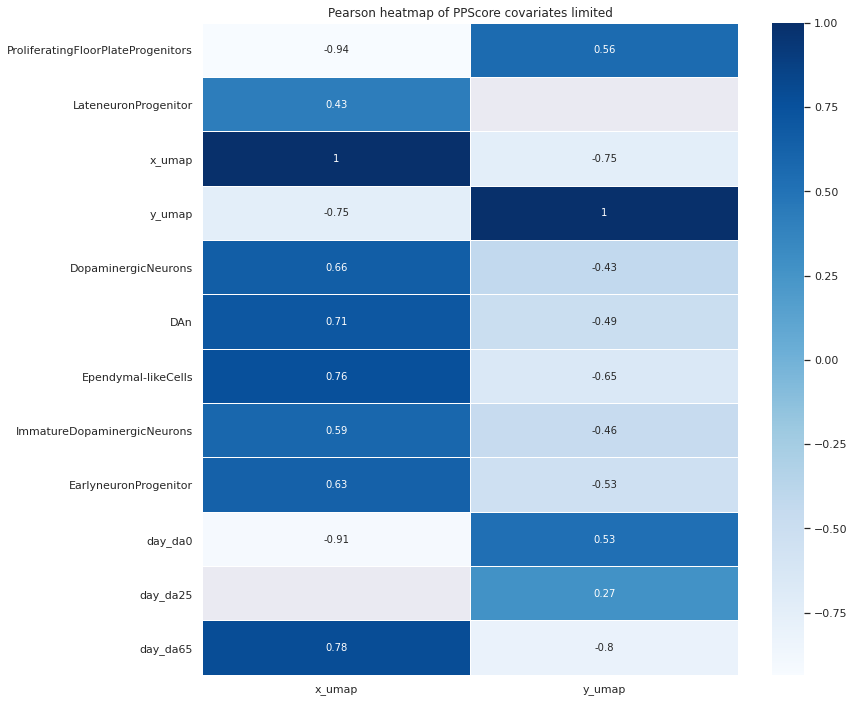

CPU times: user 14.4 s, sys: 242 ms, total: 14.6 s
Wall time: 14.6 s


In [41]:
%%time
umap_df = generate_umap_covs_df(residuals_df, covs_df)
covs_to_check = pps_predict_targets(umap_df, covs_target_list)
plot_ppscore_matrix(umap_df, covs_to_check, covs_target_list)
umap_dums_covs_df = dummy_covs_as_needed(umap_df[(set(covs_to_check) | 
                                                  set(covs_target_list))])
plot_correlation_heatmap(umap_dums_covs_df)
plot_correlation_heatmap(umap_dums_covs_df, covs_target_list)

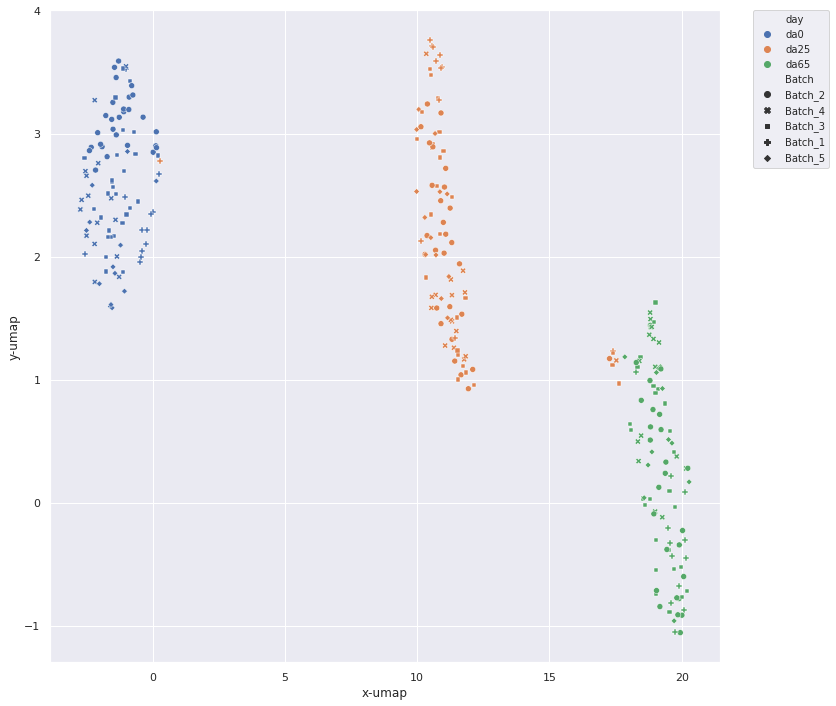

In [42]:
plot_umap_clusters(umap_df, hue_cov='day', style_cov='Batch')